In [21]:
from tqdm import tqdm
import torch
from torch.nn.functional import binary_cross_entropy
from esm_ecn.data import train_data_loader, val_data_loader, test_data_loader
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
from esm_ecn.model import MLP
from esm_ecn.train import load_best_checkpoint

model_type = "esmc_300m"
cls = True
batch_size = 32

In [22]:
train_loader = train_data_loader(model_type, batch_size, cls)
train_X, train_y = train_loader.dataset.tensors
val_loader = val_data_loader(model_type, batch_size, cls)
test_loader = test_data_loader(model_type, batch_size, cls)
test_y = test_loader.dataset.tensors[1]
train_X, train_y, test_y = train_X.cuda(), train_y.cuda().float(), test_y.cuda().float()

Loading train embeddings
Loaded embeddings, shape: torch.Size([178302, 960])
Loading train labels
Loaded labels, shape: torch.Size([178302, 4793])
Loading dev embeddings
Loaded embeddings, shape: torch.Size([23010, 960])
Loading dev labels
Loaded labels, shape: torch.Size([23010, 4793])
Loading test embeddings
Loaded embeddings, shape: torch.Size([22183, 960])
Loading test labels
Loaded labels, shape: torch.Size([22183, 4793])


In [57]:
def evaluate_model(y_hat, test_y, test_indices, thresholds=[0.001, 0.01, 0.1, 0.5, 0.9]):
    y_hat_total = y_hat.sum(dim=1)
    accuracy = torch.argmax(y_hat, dim=1).eq(test_y.argmax(dim=1)).float().mean().item()
    print(f"Accuracy: {accuracy}, Min total: {y_hat_total.min().item()}, Max total: {y_hat_total.max().item()}")
    for threshold in thresholds:
        y_hat_binary = (y_hat > threshold).float()
        test_y_binary = test_y.float()
        y_hat_binary = y_hat_binary[:, test_indices]
        test_y_binary = test_y_binary[:, test_indices]
        
        f1 = f1_score(test_y_binary.cpu().numpy(), y_hat_binary.cpu().numpy(), average='macro')
        precision = precision_score(test_y_binary.cpu().numpy(), y_hat_binary.cpu().numpy(), average='macro')
        recall = recall_score(test_y_binary.cpu().numpy(), y_hat_binary.cpu().numpy(), average='macro')
        
        print(f"\n\tThreshold: {threshold}, F1 Score: {f1}, Precision: {precision}, Recall: {recall}")


# kNN using ESMC cls embeddings

In [58]:
k = 10

In [59]:

y_hat = []
for x, y in tqdm(test_loader):
    dist = torch.cdist(x, train_X)
    _, idx = dist.topk(k, dim=1, largest=False)
    y_hat.append(train_y[idx].mean(dim=1))
y_hat = torch.cat(y_hat)
print(binary_cross_entropy(y_hat, test_y))


100%|██████████| 694/694 [00:03<00:00, 194.12it/s]


tensor(0.0009, device='cuda:0')


In [60]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

print()

test_indices = torch.nonzero(train_y.sum(dim=0) > 10).squeeze()
evaluate_model(y_hat, test_y, test_indices)


Accuracy: 0.8858585953712463, Min total: 1.0, Max total: 6.0

	Threshold: 0.001, F1 Score: 0.5824677571135342, Precision: 0.47980719067219535, Recall: 0.8653026308151763

	Threshold: 0.01, F1 Score: 0.5824677571135342, Precision: 0.47980719067219535, Recall: 0.8653026308151763

	Threshold: 0.1, F1 Score: 0.7083438129576068, Precision: 0.6642596534556124, Recall: 0.8169026478890907

	Threshold: 0.5, F1 Score: 0.6879775357164791, Precision: 0.7574234564871714, Recall: 0.6594183728802021

	Threshold: 0.9, F1 Score: 0.5909258427923845, Precision: 0.6926315271581659, Recall: 0.5431405184854445


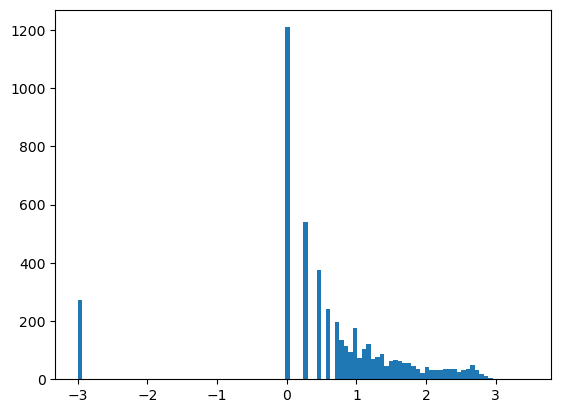

In [61]:
class_counts = train_y.sum(dim=0)
class_counts = torch.log10(class_counts + 0.001)
plt.hist(class_counts.cpu().numpy(), bins=100)
plt.show()

# Sigmoid Results

In [62]:

mlp = MLP(input_dim=train_X.shape[1], output_dim=test_y.shape[1], sigmoid=True)
model = load_best_checkpoint("9fk9o9hj", mlp, focal_loss=False, lr=0.0001).cuda()

/home/ishan/esm-ecn/src/esm_ecn/train.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [63]:
y_hat = []
with torch.no_grad():
    model.eval()
    for x, y in tqdm(test_loader):
        y_hat.append(model(x).detach())
    y_hat = torch.cat(y_hat)
print(binary_cross_entropy(y_hat, test_y))

100%|██████████| 694/694 [00:00<00:00, 2119.07it/s]

tensor(0.0019, device='cuda:0')


In [64]:
evaluate_model(y_hat, test_y, test_indices)

Accuracy: 0.017130235210061073, Min total: 0.9763228297233582, Max total: 7.725608825683594

	Threshold: 0.001, F1 Score: 0.0013871767185567312, Precision: 0.0008126616238817055, Recall: 0.17653991897297616

	Threshold: 0.01, F1 Score: 0.0001275106137451681, Precision: 0.0002552323791953309, Recall: 0.0021418031328115945

	Threshold: 0.1, F1 Score: 0.0, Precision: 0.0, Recall: 0.0

	Threshold: 0.5, F1 Score: 0.0, Precision: 0.0, Recall: 0.0

	Threshold: 0.9, F1 Score: 0.0, Precision: 0.0, Recall: 0.0


# Softmax Results

In [65]:
mlp = MLP(input_dim=train_X.shape[1], output_dim=test_y.shape[1], sigmoid=False)
model = load_best_checkpoint("6b0eti2x", mlp, focal_loss=False, lr=0.0001).cuda()

/home/ishan/esm-ecn/src/esm_ecn/train.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [66]:
y_hat = []
with torch.no_grad():
    model.eval()
    for x, y in tqdm(test_loader):
        y_hat.append(model(x).detach())
    y_hat = torch.cat(y_hat)
y_hat = torch.softmax(y_hat, dim=1)
from torch.nn.functional import cross_entropy
print(cross_entropy(y_hat, test_y.argmax(dim=1)))
print(binary_cross_entropy(y_hat, test_y))

100%|██████████| 694/694 [00:00<00:00, 2415.75it/s]

tensor(8.3576, device='cuda:0')
tensor(0.0012, device='cuda:0')


In [67]:
evaluate_model(y_hat, test_y, test_indices)

Accuracy: 0.3022134304046631, Min total: 0.9999997615814209, Max total: 1.000000238418579

	Threshold: 0.001, F1 Score: 0.013973076329401554, Precision: 0.007177023749389114, Recall: 0.7592439303401102

	Threshold: 0.01, F1 Score: 0.05200012313113331, Precision: 0.03485424011598886, Recall: 0.3953781755892908

	Threshold: 0.1, F1 Score: 0.07180003328565349, Precision: 0.0802311436159907, Recall: 0.09058268386525266

	Threshold: 0.5, F1 Score: 0.011126942107923858, Precision: 0.027591396173051, Recall: 0.008246897731435813

	Threshold: 0.9, F1 Score: 0.0009960993790057134, Precision: 0.002758583585498958, Recall: 0.000684950506232294
